In [0]:
#!pip3 install torch torchvision
#!pip3 install torch --upgrade

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.ndimage.interpolation import shift
from sklearn.metrics import r2_score as reg_acc
from sklearn.metrics import mean_squared_error as mse
from sklearn.neural_network import MLPRegressor as NN
from statsmodels.tsa.arima_model import ARIMA
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
features=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/features.csv')

In [0]:
stores=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/stores.csv')

In [0]:
train=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/train.csv')

In [0]:
merged_1=train.merge(stores, on=['Store'], how='left')

In [0]:
train=merged_1.merge(features, on=['Store','Date','IsHoliday'], how='left')

In [0]:
nan_values=train.isnull()
nan_values_count=[0]*train.shape[1]
for i in range(train.shape[1]):
  nan_values_count[i]=sum(nan_values.iloc[:,i])

In [0]:
train['MarkDown1']=train['MarkDown1'].fillna(0)
train['MarkDown2']=train['MarkDown2'].fillna(0)
train['MarkDown3']=train['MarkDown3'].fillna(0)
train['MarkDown4']=train['MarkDown4'].fillna(0)
train['MarkDown5']=train['MarkDown5'].fillna(0)

In [0]:
train['month']=pd.DatetimeIndex(train['Date']).month
train['day']=pd.DatetimeIndex(train['Date']).day
train['Type']=train['Type'].astype('category')
train['StoreType']=train['Type'].cat.codes
train=train.drop('Type',axis=1)
train['date']=train['Date']
train=train.drop('Date',axis=1)

In [0]:
test=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/test.csv')

In [0]:
merged_1=test.merge(stores, on=['Store'], how='left')
test=merged_1.merge(features, on=['Store','Date','IsHoliday'], how='left')
nan_values=test.isnull()
nan_values_count=[0]*test.shape[1]
for i in range(test.shape[1]):
  nan_values_count[i]=sum(nan_values.iloc[:,i])
test['MarkDown1']=test['MarkDown1'].fillna(0)
test['MarkDown2']=test['MarkDown2'].fillna(0)
test['MarkDown3']=test['MarkDown3'].fillna(0)
test['MarkDown4']=test['MarkDown4'].fillna(0)
test['MarkDown5']=test['MarkDown5'].fillna(0)
test['CPI']=test['CPI'].fillna(np.mean(test['CPI']))
test['Unemployment']=test['Unemployment'].fillna(np.mean(test['Unemployment']))
test['month']=pd.DatetimeIndex(test['Date']).month
test['day']=pd.DatetimeIndex(test['Date']).day
test['Type']=test['Type'].astype('category')
test['StoreType']=test['Type'].cat.codes
test=test.drop('Type',axis=1)
test['date']=test['Date']
test=test.drop('Date',axis=1)

In [0]:
train['sales']=train['Weekly_Sales']
train=train.drop('Weekly_Sales',axis=1)

In [16]:
print(train.shape)
print(test.shape)

(421570, 18)
(115064, 17)


In [0]:
time_outputs=30
time_stamps=30

In [0]:
store1=sum(train['Dept']==1)
store1=10000

In [0]:
train=train.iloc[:store1,:]

In [0]:
date=train['date']
train=train.drop('date',axis=1)

In [0]:
train=train['sales']

In [0]:
train=train.as_matrix()

In [0]:
train=train[train>0]

In [0]:
#train=np.log(train)

In [0]:
indices=[]
for i in range(train.shape[0]):
  if train[i]==0:
    indices.append(i)

In [26]:
indices

[]

In [0]:
#train=np.log(train)
scaler=MinMaxScaler(feature_range=(-1, 1))

In [0]:
scaler.fit(train.reshape(-1,1))
train=scaler.transform(train.reshape(-1,1))
train=train.reshape(-1)

In [0]:
def series_to_supervised(data,time_stamps=30):
  count=data.shape[0]-time_stamps-1
  X=np.zeros((count,time_stamps))
  Y=np.zeros((count,time_outputs))
  print(count)
  for i in range(count):
    X[i,:]=data[i:time_stamps+i]
    Y[i,:]=data[i+1:time_stamps+i+1]
    
  train_x=X[: int(0.8*X.shape[0])]
  train_y=Y[: int(0.8*Y.shape[0])]
  test_x=X[int(0.8*X.shape[0]) :]
  test_y=Y[int(0.8*Y.shape[0]) :]
  
  return train_x,train_y,test_x,test_y

In [30]:
train_x,train_y,test_x,test_y=series_to_supervised(train,time_stamps=time_stamps)

9951


In [31]:
test_x.shape

(1991, 30)

In [0]:
#scaler= np.max(train_x)

In [0]:
#train_x=train_x/scaler
#test_x=test_x/scaler
#train_y=train_y/scaler
#test_y=test_y/scaler

In [0]:
train_x=train_x.reshape(-1,time_stamps,1)
test_x=test_x.reshape(-1,time_stamps,1)
train_y=train_y.reshape(-1,time_outputs)
test_y=test_y.reshape(-1,time_outputs)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
device

device(type='cuda')

In [0]:
class LSTM(nn.Module):

    def __init__(self,features,batch,time_stamps,time_outputs,num_layers=1,hidden_blocks=1):
        super(LSTM, self).__init__()
        self.time_outputs = time_outputs
        self.features = features
        self.num_layers = num_layers
        self.hidden_blocks=hidden_blocks
        self.time_stamps=time_stamps
        self.batch=batch
        self.lstm = nn.LSTM(input_size=self.features, hidden_size=self.hidden_blocks, num_layers=self.num_layers)#,batch_first=True)
        self.linear = nn.Linear(self.time_stamps,self.time_outputs)
        self.hidden = self.init_hidden()
    def init_hidden(self):
      return [torch.zeros(self.num_layers, self.time_stamps, self.hidden_blocks).to(device),
                torch.zeros(self.num_layers, self.time_stamps, self.hidden_blocks).to(device)]

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        b,s,h=input.size()
        input=input.view(s,b,h)
        out,self.hidden = self.lstm(input,self.hidden)
        b,s,h=out.size()
        out=out.view(b,-1)
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        #y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        out=self.linear(out)
        out=F.tanh(out)
        out = out.view(s,b,1)
        return out



In [0]:
def test_model(prev,test_y,model,device,time_stamps):
  temp=test_x[0,:,:]
  temp=torch.from_numpy(temp).float().to(device)
  temp=temp.view(time_stamps,-1,1)
  out=model(temp)
  a=out.detach().cpu().numpy()
  a=np.squeeze(a)

  prev=prev.reshape(-1,1,1)
  prev=torch.from_numpy(prev).float().to(device)
  test_y=test_y[:1000]
  prediction=[]
  for i in range(test_y.shape[0]):
    out=model(prev)
    #prev=np.squeeze(prev)
    #for j in range(time_outputs):
    #  prev=shift(prev, -1, cval=out[0,j])
    #print(out.shape)
    prediction.append(out[0,-1].detach().cpu().numpy())
    prev=out
    prev=prev.view(-1,1,1)
  plt.figure()
  plt.plot(a)
  plt.plot(np.squeeze(test_y[0,:]))
  plt.title('model prediction')
  plt.show()
  plt.figure()
  plt.plot(prediction)
  plt.title('forecasting')
  plt.show()

In [39]:
Epochs=100
hidden_dim=100
batch=2
features=1
layers=1
model = LSTM(features,batch,time_stamps,time_outputs,num_layers=layers)
model=model.cuda()
with torch.no_grad():
    inputs = torch.randn(time_stamps,batch,1).float().to(device)
    tag_scores = model(inputs)
    print(tag_scores.size())

torch.Size([30, 2, 1])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 1 Batch: 0 MSE Loss: tensor(0.7069, device='cuda:0')


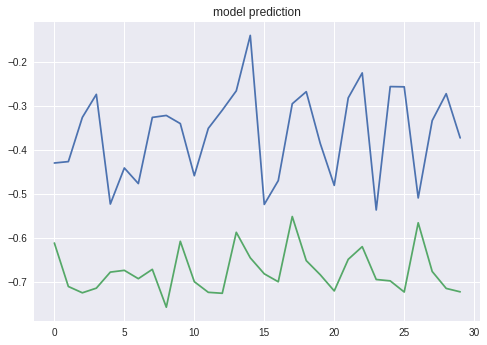

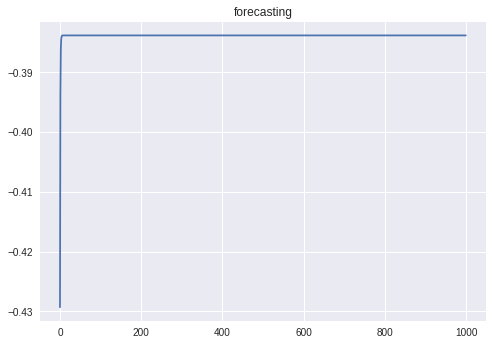

Epoch: 2 Batch: 0 MSE Loss: tensor(0.0239, device='cuda:0')


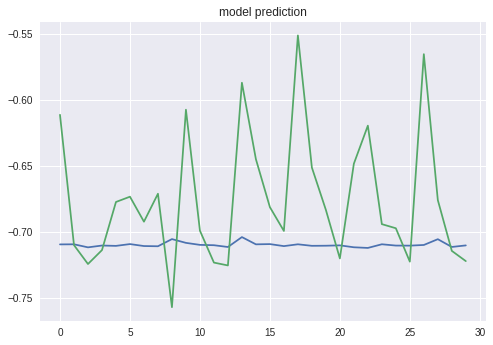

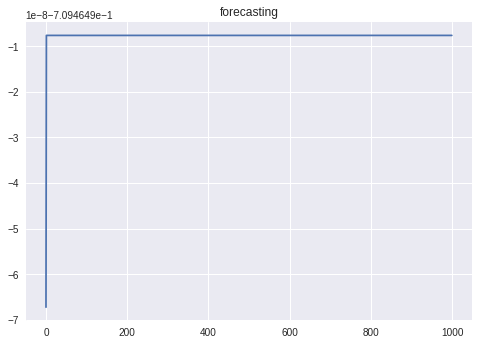

Epoch: 3 Batch: 0 MSE Loss: tensor(0.0232, device='cuda:0')


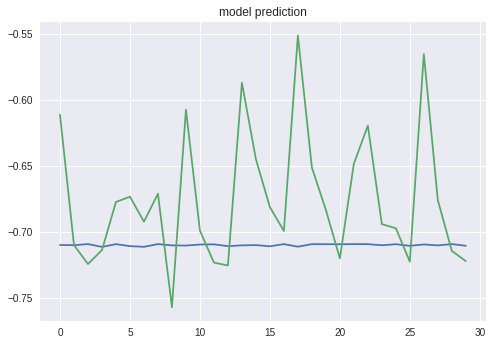

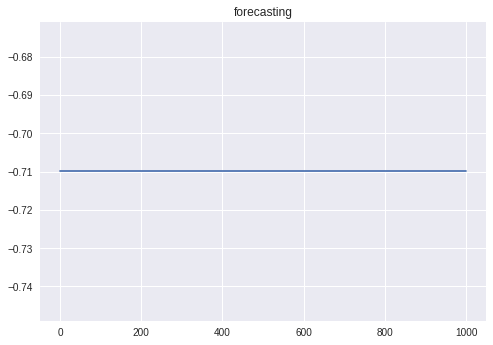

Epoch: 4 Batch: 0 MSE Loss: tensor(0.0226, device='cuda:0')


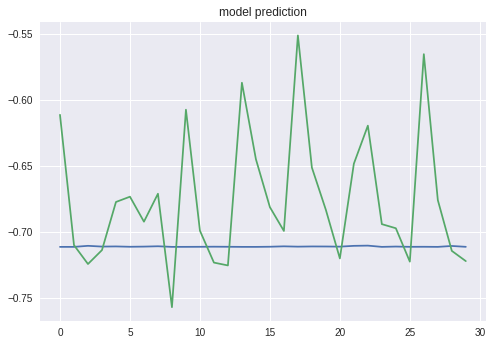

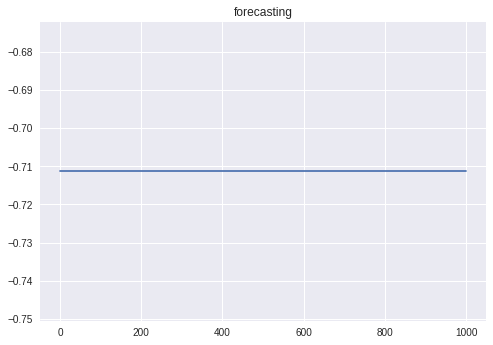

Epoch: 5 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


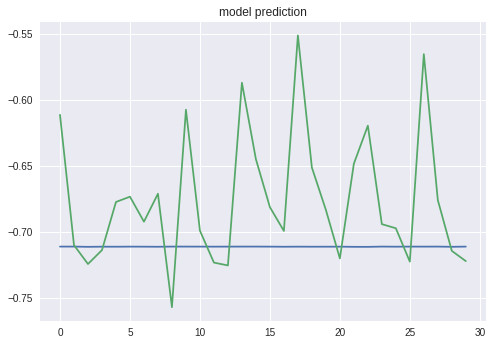

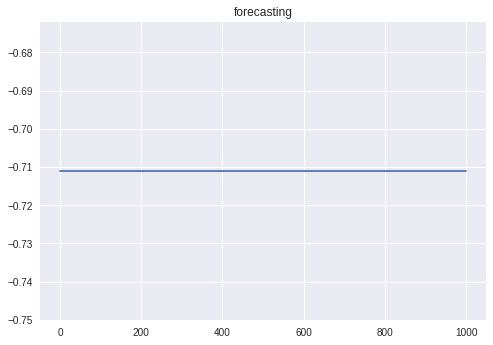

Epoch: 6 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


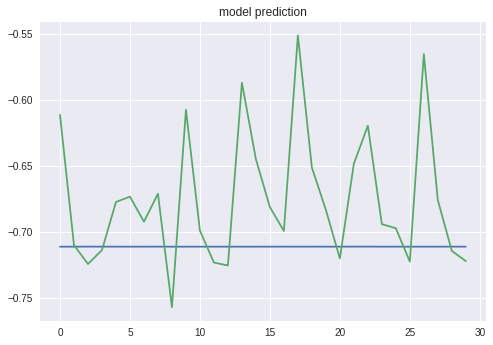

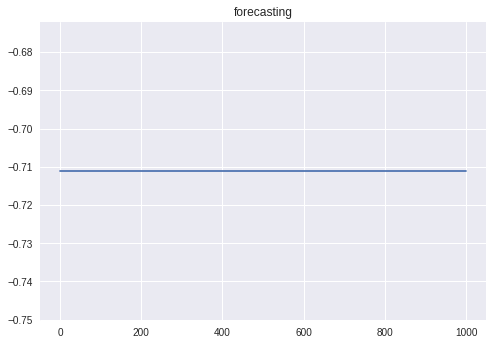

Epoch: 7 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


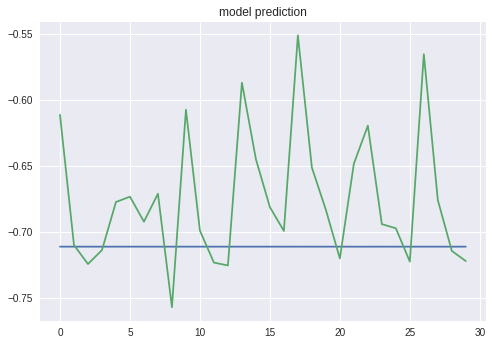

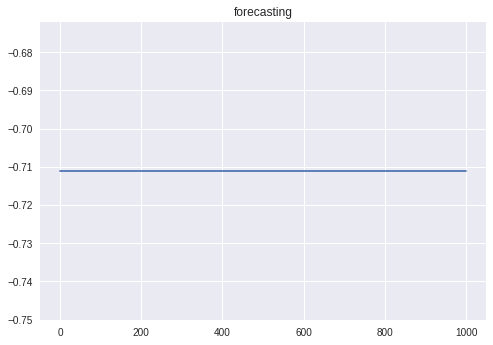

Epoch: 8 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


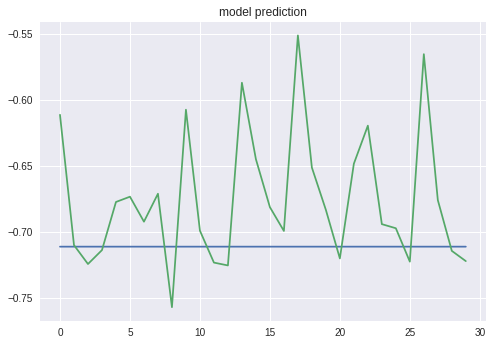

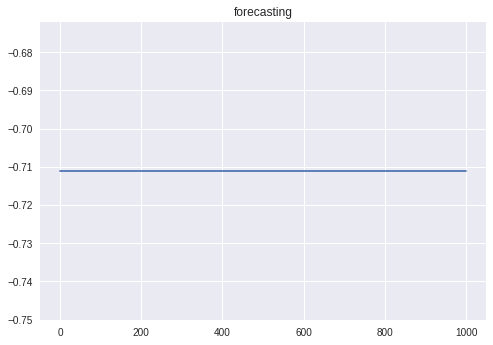

Epoch: 9 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


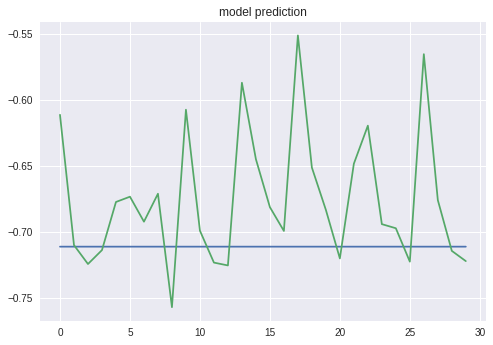

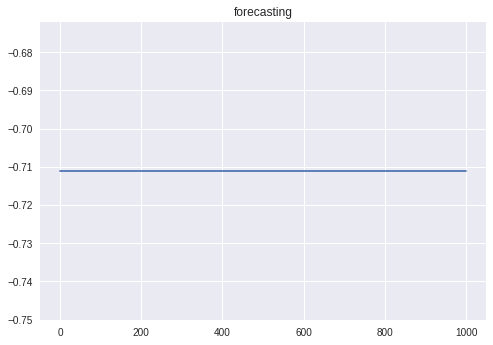

Epoch: 10 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


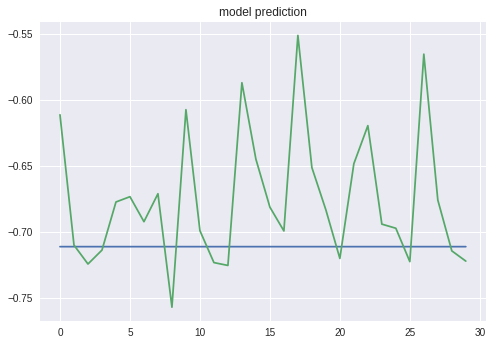

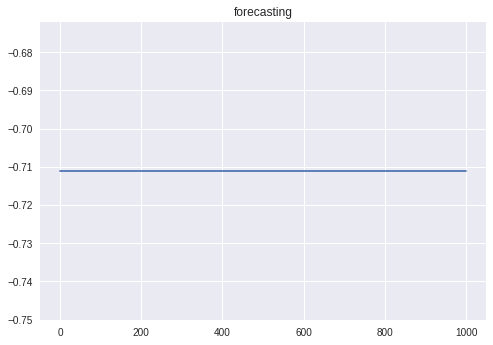

Epoch: 11 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


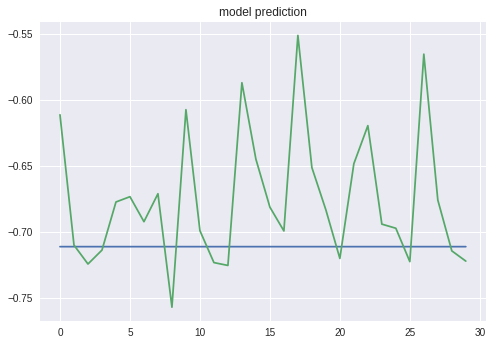

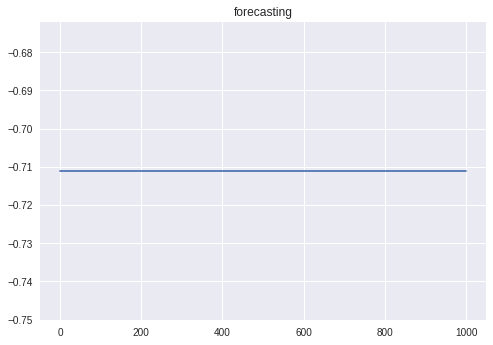

Epoch: 12 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


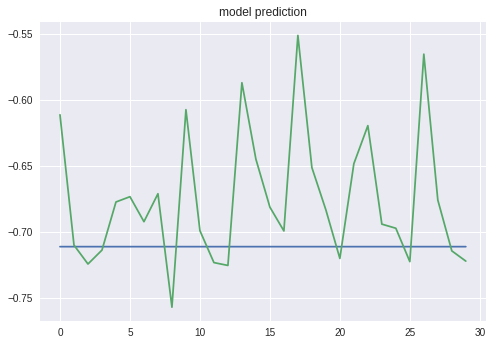

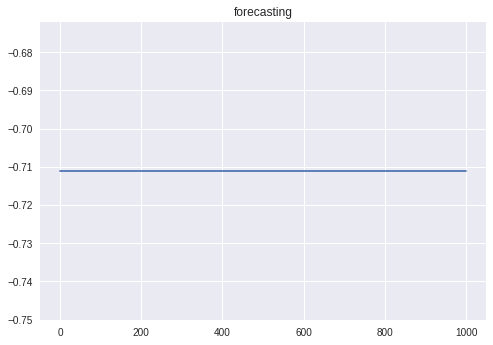

Epoch: 13 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


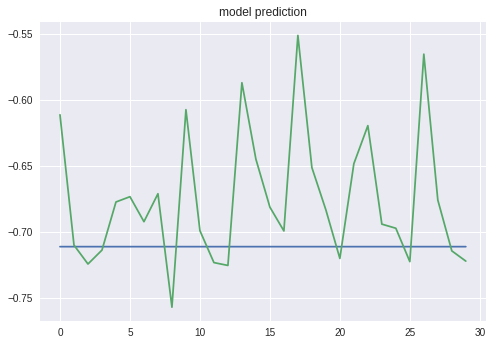

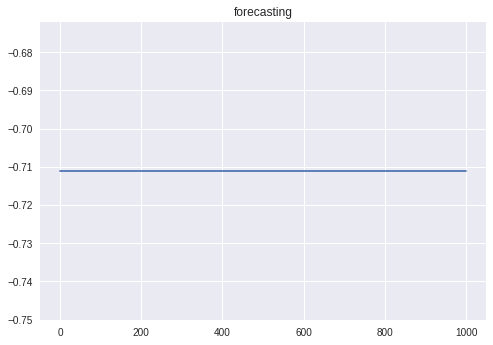

Epoch: 14 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


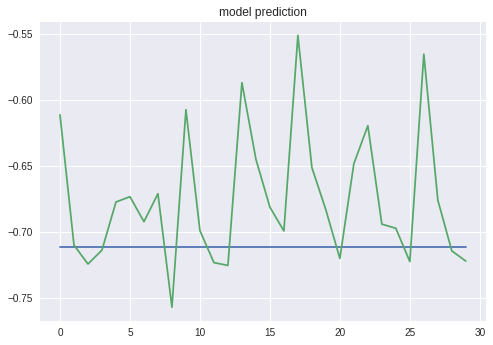

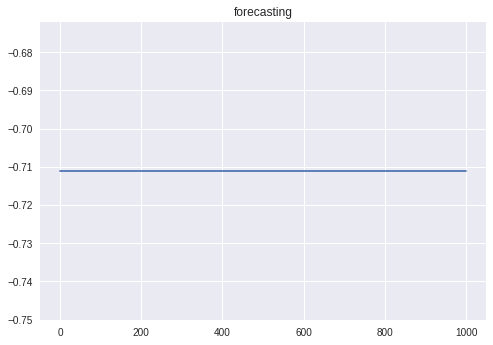

Epoch: 15 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


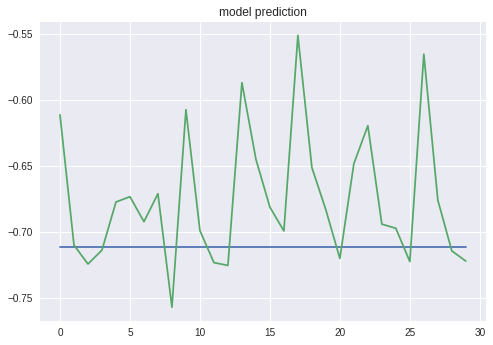

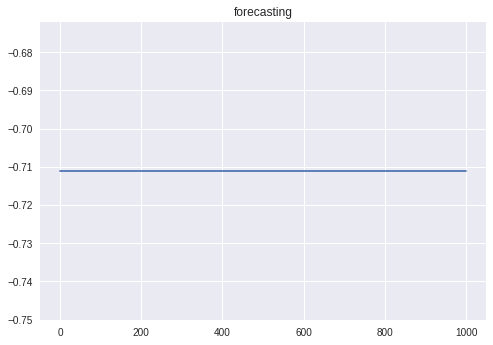

Epoch: 16 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


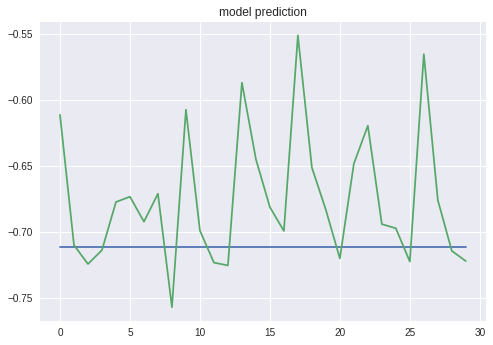

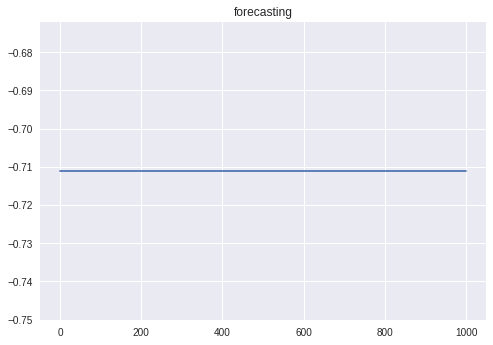

Epoch: 17 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


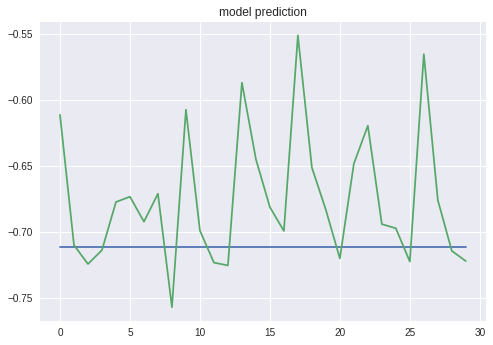

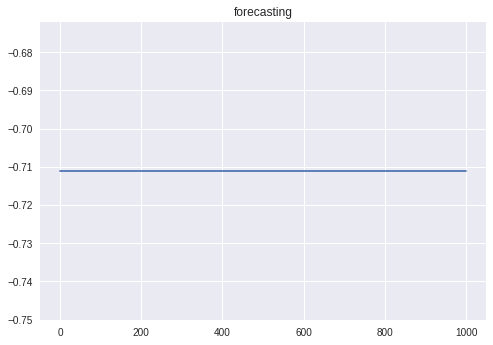

Epoch: 18 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


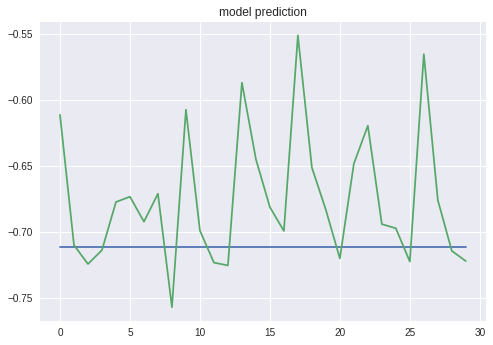

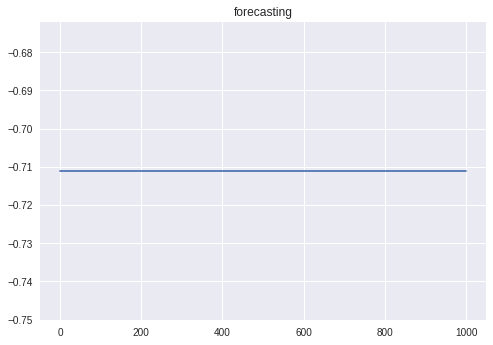

Epoch: 19 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


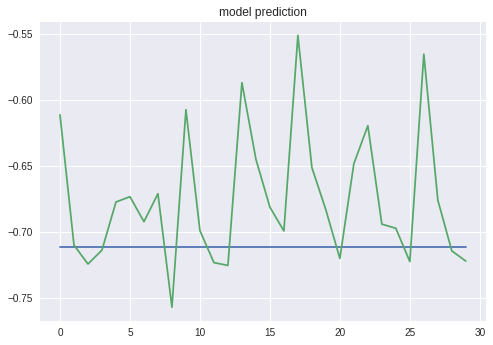

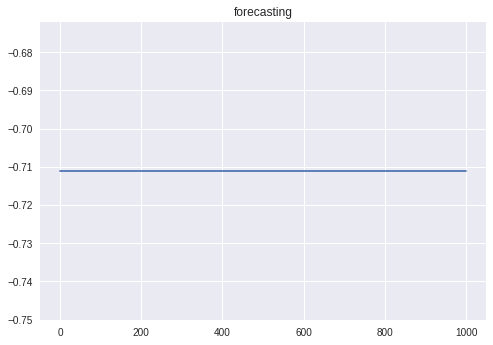

Epoch: 20 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


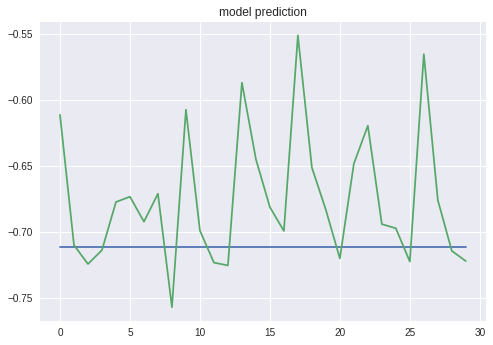

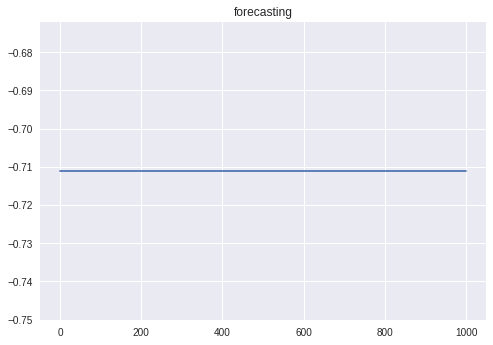

Epoch: 21 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


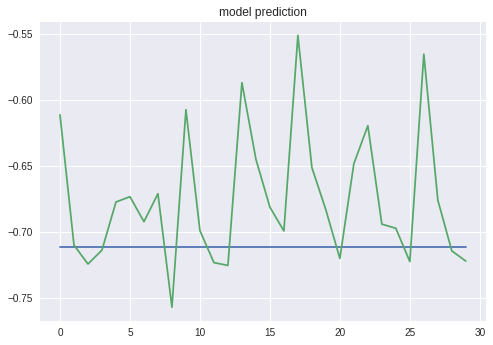

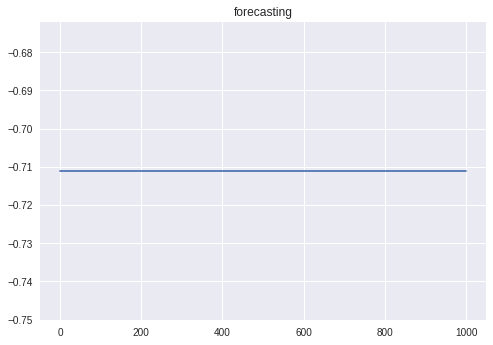

Epoch: 22 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


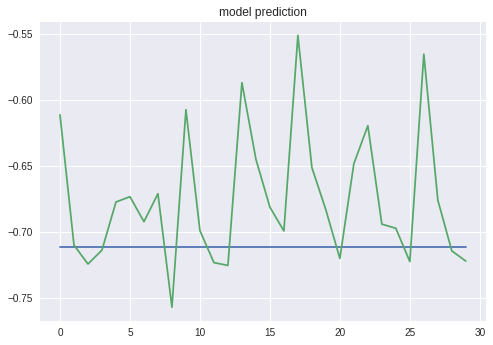

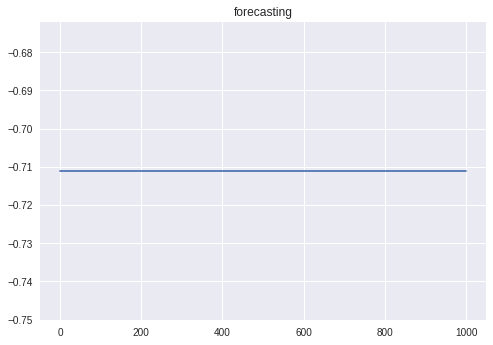

Epoch: 23 Batch: 0 MSE Loss: tensor(0.0225, device='cuda:0')


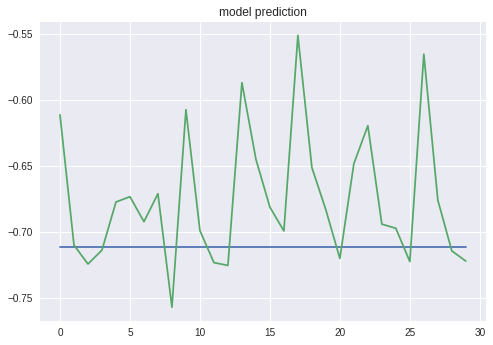

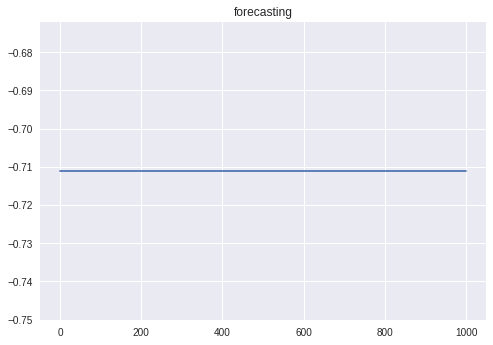

KeyboardInterrupt: ignored

In [41]:
Epochs=100
hidden_dim=1
batch=1
features=1
layers=1
model = LSTM(features,batch,time_stamps,time_outputs,num_layers=layers)
model=model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss = nn.MSELoss()
for i in range(Epochs):
  for j in range(int(train_y.shape[0]/batch)):
    model.zero_grad()
    model.hidden = model.init_hidden()
    batch_x=torch.from_numpy(train_x[j*batch:(j+1)*batch,:,:])
    batch_y=torch.from_numpy(train_y[j*batch:(j+1)*batch,:]).float().to(device)
    batch_x=batch_x.view(time_stamps,batch,1)
    batch_x=batch_x.float().to(device)
    output=model(batch_x)
    Netloss = loss(output,batch_y)
    Netloss.backward()
    optimizer.step()
    if j%100000==0:
      print('Epoch:',i+1,'Batch:',j,'MSE Loss:',Netloss.data)
      test_model(train_x[-1,:],test_y,model,device,time_stamps)

In [0]:
reg_acc(test_y*scaler,prediction*scaler)

In [0]:
mse(test_y*scaler,prediction*scaler)

In [0]:
temp=test.iloc[:, 0:15].as_matrix()

In [0]:
temp=scaler_x.transform(temp)

In [0]:
temp=temp.reshape(-1,1,15)

In [0]:
test_prediction=model.predict(temp)

In [0]:
test_prediction=test_prediction*scaler_y

In [0]:
test_prediction

In [0]:
submission=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/sampleSubmission.csv')

In [0]:
submission['Weekly_Sales']=test_prediction

In [0]:
submission.to_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/kaggle_submission.csv',index=False)

In [0]:
submission.head()

In [0]:
sum(train['Store']==1)

In [0]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [0]:
train.shape

In [0]:
train.head()

In [0]:
plt.plot(np.alog(train[:100]))

In [0]:
np.log(-90)